# Create plots to visualize data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.paths import path_angles
import os
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import numpy as np
from scipy.stats import ttest_rel


# Generate large dataframe


In [4]:
models = ["openpose", "alphapose"]
mocap = pd.read_csv("results/results_mocap_summarized.csv")

# Create an empty list to collect rows
rows = []

# Loop through each model
for model in models:
    # Get all participant directories that start with "P"
    participants = sorted([i for i in os.listdir(os.path.join(path_angles, model)) if i.startswith("P")])
    participants = [p for p in participants if p in mocap["Trial"].values]  # Only include participants that have mocap data
    for participant in participants:
        trial_path = os.path.join(path_angles, model, participant, "summary.csv")
        angles = pd.read_csv(trial_path, index_col=0)  # Assuming row labels are "mean", "std", etc.
        
        # Get the mocap reference values for this participant (if needed for reference)
        mocap_participant = mocap[mocap["Trial"] == participant]
        
        for angle in mocap_participant.columns:
            if angle != "Trial":
                rows.append({
                    "Participant": participant,
                    "Model": model,
                    "Angle": angle,
                    "Mean": angles.loc["mean", angle],
                    "Std": angles.loc["std", angle],
                    "Min": angles.loc["min", angle],
                    "Max": angles.loc["max", angle]
                })

# Add Mocap Reference Values
for _, row in mocap.iterrows():
    participant = row["Trial"]
    for angle in mocap.columns[1:]:
        rows.append({
            "Participant": participant,
            "Model": "mocap",
            "Angle": angle,
            "Mean": row[angle],  # Mocap mean value
            "Std": None,
            "Min": None,
            "Max": None
        })

# Create the final DataFrame from the list of dictionaries
df = pd.DataFrame(rows)

# Save the tidy results to a CSV file
df.to_csv("results/tidy_results.csv", index=False)

# Statistical analysis

In [5]:
# Load your tidy data
df = pd.read_csv("results/tidy_results.csv")

# Pivot the data so that each row is a Participant and Angle,
# with columns for each model's mean values (mocap, alphapose, openpose)
df_pivot = df.pivot_table(index=["Participant", "Angle"], columns="Model", values="Mean").reset_index()

def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

angles = df_pivot["Angle"].unique()
models_to_compare = ["alphapose", "openpose"]

results = []

for angle in angles:
    subset = df_pivot[df_pivot["Angle"] == angle]
    for model in models_to_compare:
        if model in subset.columns:
            # Calculate the error: difference between pose estimation and mocap values
            error = subset[model] - subset["mocap"]
            rmse_val = rmse(subset[model], subset["mocap"])
            mae_val = np.mean(np.abs(error))
            bias = np.mean(error)
            sd = np.std(error, ddof=1)  # sample standard deviation
            
            intrasubject_variability = max(subset["mocap"]) - min(subset["mocap"])
            
            # Calculate Limits of Agreement (LoA)
            loa_lower = bias - 1.96 * sd
            loa_upper = bias + 1.96 * sd
            
            # Perform a paired t-test to see if the bias is significantly different from zero
            t_stat, p_val = ttest_rel(subset[model], subset["mocap"])
            
            results.append({
                "Angle": angle,
                "Model": model,
                "RMSE": rmse_val,
                "MAE": mae_val,
                "Bias": bias,
                "SD": sd,
                "LoA_lower": loa_lower,
                "LoA_upper": loa_upper,
                "Confidence Interval": loa_upper - loa_lower,
                "Intrasubject Variability": intrasubject_variability,
                "t_stat": t_stat,
                "p_val": p_val
            })

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("results/statistics.csv", index=False)
results_df

                   Angle      Model       RMSE        MAE       Bias  \
0   TD_Ankledorsiflexion  alphapose   2.021969   1.661191  -0.024514   
1   TD_Ankledorsiflexion   openpose   5.851759   5.310625   5.200442   
2          TD_Hipflexion  alphapose  10.182550   9.258582  -9.258582   
3          TD_Hipflexion   openpose   8.811704   7.603037  -7.603037   
4       TD_Kneeadduction  alphapose   4.224955   3.956869   3.956869   
5       TD_Kneeadduction   openpose   2.378404   1.786588  -0.006746   
6         TD_Kneeflexion  alphapose   5.401859   4.383756  -4.383756   
7         TD_Kneeflexion   openpose   4.596675   3.403565  -2.939753   
8   TO_Ankledorsiflexion  alphapose  13.224212  12.663399  12.663399   
9   TO_Ankledorsiflexion   openpose  16.922859  16.338299  16.338299   
10         TO_Hipflexion  alphapose  15.289003  14.859177 -14.859177   
11         TO_Hipflexion   openpose  13.085834  12.559029 -12.559029   
12      TO_Kneeadduction  alphapose   9.984502   9.137389  -9.13

,Angle,Model,RMSE,MAE,Bias,SD,LoA_lower,LoA_upper,Confidence Interval,Intrasubject Variability,t_stat,p_val
0,TD_Ankledorsiflexion,alphapose,2.021969,1.661191,-0.024514,2.120504,-4.180701,4.131673,8.312374,8.699526,-0.038342,9.701695e-01
1,TD_Ankledorsiflexion,openpose,5.851759,5.310625,5.200442,2.813955,-0.314910,10.715793,11.030702,8.699526,6.129421,1.112930e-04
2,TD_Hipflexion,alphapose,10.182550,9.258582,-9.258582,4.445142,-17.971060,-0.546103,17.424956,14.501733,-6.908045,4.153504e-05
3,TD_Hipflexion,openpose,8.811704,7.603037,-7.603037,4.671611,-16.759395,1.553320,18.312715,14.501733,-5.397800,3.023608e-04
4,TD_Kneeadduction,alphapose,4.224955,3.956869,3.956869,1.553313,0.912374,7.001363,6.088988,1.419968,8.448681,7.278211e-06
5,TD_Kneeadduction,openpose,2.378404,1.786588,-0.006746,2.494481,-4.895928,4.882436,9.778365,1.419968,-0.008969,9.930199e-01
6,TD_Kneeflexion,alphapose,5.401859,4.383756,-4.383756,3.310445,-10.872228,2.104717,12.976945,6.997145,-4.391939,1.351963e-03
7,TD_Kneeflexion,openpose,4.596675,3.403565,-2.939753,3.706210,-10.203926,4.324419,14.528344,6.997145,-2.630736,2.513041e-02
8,TO_Ankledorsiflexion,alphapose,13.224212,12.663399,12.663399,3.996239,4.830770,20.496028,15.665258,15.342855,10.509817,1.005882e-06
9,TO_Ankledorsiflexion,openpose,16.922859,16.338299,16.338299,4.624655,7.273976,25.402623,18.128647,15.342855,11.717201,3.654740e-07


# 1. Comparison between participants

In [6]:
# Load the tidy data (adjust the path if needed)
df = pd.read_csv("results/tidy_results.csv")

# Create the "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Get the unique angles and participants
angles_list = df["Angle"].unique()
participants = sorted(df["Participant"].unique())

# Define model colors and bar width
color_alphapose = "blue"
color_openpose = "green"
color_mocap = "red"
bar_width = 0.2  # width for positioning the model plots

# Create a mapping for participant positions on the x-axis
x_positions = {p: i for i, p in enumerate(participants)}

# Loop over each angle to generate a plot
for angle in angles_list:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # For each participant, plot the model and mocap data
    for p in participants:
        x = x_positions[p]
        # Filter rows for current participant and angle (should be three: alphapose, openpose, mocap)
        subset = df[(df["Participant"] == p) & (df["Angle"] == angle)]
        
        for _, row in subset.iterrows():
            model = row["Model"]
            if model in ["alphapose", "openpose"]:
                # Determine x offset and color based on model
                if model == "alphapose":
                    x_offset = x - bar_width/2
                    color = color_alphapose
                else:  # openpose
                    x_offset = x + bar_width/2
                    color = color_openpose
                
                mean_val = row["Mean"]
                std_val = row["Std"]
                min_val = row["Min"]
                max_val = row["Max"]
                
                # Draw the rectangle for ± std (std box)
                if pd.notnull(std_val):
                    std_box_bottom = mean_val - std_val
                    std_box_height = 2 * std_val
                    rect = Rectangle((x_offset - bar_width/2, std_box_bottom),
                                     bar_width,
                                     std_box_height,
                                     alpha=0.3,
                                     color=color)
                    ax.add_patch(rect)
                
                # Draw whiskers: vertical lines from min to (mean - std) and from (mean + std) to max
                ax.vlines(x_offset, min_val, mean_val - std_val, color=color, linewidth=2)
                ax.vlines(x_offset, mean_val + std_val, max_val, color=color, linewidth=2)
                
                # Draw horizontal caps at min and max (short lines)
                cap_width = bar_width / 2
                ax.hlines(min_val, x_offset - cap_width/2, x_offset + cap_width/2, color=color, linewidth=2)
                ax.hlines(max_val, x_offset - cap_width/2, x_offset + cap_width/2, color=color, linewidth=2)
                
                # Optionally, you can also draw a horizontal line at the mean if you want to emphasize it.
                ax.hlines(mean_val, x_offset - bar_width/2, x_offset + bar_width/2, color=color, linewidth=2)
            
            elif model == "mocap":
                # For mocap, draw a red horizontal line spanning the two model positions (for comparison)
                ax.hlines(row["Mean"], x - bar_width, x + bar_width, color=color_mocap, linewidth=2)
    
    # Configure x-axis with participant labels
    ax.set_xticks(list(x_positions.values()))
    ax.set_xticklabels(list(x_positions.keys()))
    
    # Set labels, title, and grid
    ax.set_xlabel("Participant")
    ax.set_ylabel(f"{angle} (°)")
    ax.set_title(f"Comparison of {angle} Across Participants")
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    ax.xaxis.grid(False)
    
    # Create a custom legend
    legend_elements = [
        Line2D([0], [0], color=color_alphapose, lw=4, label="Alphapose"),
        Line2D([0], [0], color=color_openpose, lw=4, label="Openpose"),
        Line2D([0], [0], color=color_mocap, lw=4, label="Mocap")
    ]
    ax.legend(handles=legend_elements)
    
    # Save the figure into the "plots" directory
    plot_filename = os.path.join("plots", f"Comparison_{angle}.png")
    plt.tight_layout()
    plt.savefig(plot_filename)
    #plt.show()
    plt.close()


# 2. Errorbar Plot

In [7]:
# Load the tidy data (adjust the path if needed)
df = pd.read_csv("results/tidy_results.csv")

# Create the "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Pivot the DataFrame so that each Participant/Angle has the mean values for each model.
# This results in columns like "alphapose", "openpose", and "mocap" containing the mean values.
df_pivot = df.pivot_table(index=["Participant", "Angle"], columns="Model", values="Mean")
df_pivot = df_pivot.reset_index()

# Get the unique angles and participants
angles = df_pivot["Angle"].unique()
participants = sorted(df_pivot["Participant"].unique())
x_positions = np.arange(len(participants))

for angle in angles:
    # Select data for the current angle
    subset = df_pivot[df_pivot["Angle"] == angle]
    
    # Initialize lists for differences for each model
    alphapose_diffs = []
    openpose_diffs = []
    
    # Loop over participants to compute differences: (model mean - mocap mean)
    for p in participants:
        row = subset[subset["Participant"] == p]
        if row.empty:
            alphapose_diffs.append(np.nan)
            openpose_diffs.append(np.nan)
        else:
            row = row.iloc[0]
            m_mean = row["mocap"]
            a_mean = row["alphapose"]
            o_mean = row["openpose"]
            alphapose_diffs.append(a_mean - m_mean)
            openpose_diffs.append(o_mean - m_mean)
    
    # For each difference, create a “one-sided” error: the error bar should extend from 0 to the difference.
    # For a positive difference, the lower error is the full difference and upper error is 0.
    # For a negative difference, the lower error is 0 and the upper error is the absolute value of the difference.
    alphapose_yerr = [(diff if diff >= 0 else 0, 0 if diff >= 0 else -diff) for diff in alphapose_diffs]
    openpose_yerr = [(diff if diff >= 0 else 0, 0 if diff >= 0 else -diff) for diff in openpose_diffs]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot alphapose differences with error bars (shift x positions slightly to the left)
    ax.errorbar(x_positions - 0.1, alphapose_diffs, yerr=np.array(alphapose_yerr).T,
                fmt='o', color='blue', capsize=5, label='Alphapose')
    
    # Plot openpose differences with error bars (shift x positions slightly to the right)
    ax.errorbar(x_positions + 0.1, openpose_diffs, yerr=np.array(openpose_yerr).T,
                fmt='o', color='green', capsize=5, label='Openpose')
    
    # Draw a horizontal dashed line at 0 to indicate no difference
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    
    # Configure x-axis with participant labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(participants)
    
    ax.set_xlabel("Participant")
    ax.set_ylabel("Difference (Model - Mocap) in degrees")
    ax.set_title(f"Error (Difference) between Pose Estimation and Mocap for {angle}")
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)
    ax.xaxis.grid(False)
    ax.legend()
    
    # Save the figure into the "plots" directory
    plot_filename = os.path.join("plots", f"Errorplot_{angle}.png")
    plt.tight_layout()
    plt.savefig(plot_filename)
    #plt.show()
    plt.close()

# 3. Bland-Altman Plot

In [8]:
# Load the tidy data (adjust the path if needed
df = pd.read_csv("results/tidy_results.csv")

# Create the "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Pivot the DataFrame so that each row corresponds to a Participant and Angle
# with columns for the mean values of each model (alphapose, openpose, mocap)
df_pivot = df.pivot_table(index=["Participant", "Angle"], columns="Model", values="Mean").reset_index()

# Get the unique angles and define the models to analyze
angles = df_pivot["Angle"].unique()
models = ["alphapose", "openpose"]

# Loop through each angle and model to create Bland–Altman plots
for angle in angles:
    # Filter for the current angle
    subset = df_pivot[df_pivot["Angle"] == angle]
    
    for model in models:
        # Calculate the average measurement and the difference (model - mocap)
        averages = (subset[model] + subset["mocap"]) / 2
        differences = subset[model] - subset["mocap"]
        
        # Compute mean difference and standard deviation of the differences
        mean_diff = np.mean(differences)
        std_diff = np.std(differences, ddof=1)  # sample standard deviation
        
        # Define limits of agreement: mean difference ± 1.96*std
        loa_upper = mean_diff + 1.96 * std_diff
        loa_lower = mean_diff - 1.96 * std_diff
        
        # Create the Bland–Altman plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(averages, differences, 
                   color='blue' if model == "alphapose" else 'green', 
                   label=f"{model.capitalize()} Data")
        
        # Plot horizontal lines for the mean difference and the limits of agreement
        ax.axhline(mean_diff, color='gray', linestyle='--', linewidth=2, label='Mean Difference')
        ax.axhline(loa_upper, color='red', linestyle='--', linewidth=2, label='Upper LoA')
        ax.axhline(loa_lower, color='red', linestyle='--', linewidth=2, label='Lower LoA')
        
        # Set title, labels, and grid
        ax.set_title(f"Bland–Altman Plot for {model.capitalize()} - {angle}")
        ax.set_xlabel("Average of Model and Mocap Measurements")
        ax.set_ylabel("Difference (Model - Mocap) in Degrees")
        ax.yaxis.grid(True, linestyle="--", alpha=0.7)
        ax.xaxis.grid(False)
        ax.legend()
        
        # Save the plot
        plot_filename = os.path.join("plots", f"BlandAltman_{model}_{angle}.png")
        plt.tight_layout()
        plt.savefig(plot_filename)
        #plt.show()
        plt.close()

# 4. Scatter plot

In [9]:
# Load tidy data (adjust the path if needed)
df = pd.read_csv("results/tidy_results.csv")

# Pivot the DataFrame so each row corresponds to a Participant and Angle, 
# with columns for each model's mean values (alphapose, openpose, mocap)
df_pivot = df.pivot_table(index=["Participant", "Angle"], columns="Model", values="Mean").reset_index()

# Get unique angles
angles = df_pivot["Angle"].unique()

# Create a "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

for angle in angles:
    subset = df_pivot[df_pivot["Angle"] == angle]
    
    # Create a scatter plot: x = mocap, y = pose estimation
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot alphapose data
    ax.scatter(subset["mocap"], subset["alphapose"], color="blue", label="Alphapose", marker="o")
    # Plot openpose data
    ax.scatter(subset["mocap"], subset["openpose"], color="green", label="Openpose", marker="x")
    
    # Determine plotting range
    min_val = min(subset["mocap"].min(), subset["alphapose"].min(), subset["openpose"].min())
    max_val = max(subset["mocap"].max(), subset["alphapose"].max(), subset["openpose"].max())
    
    # Plot the identity line (perfect agreement line)
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', label="Identity Line")
    
    # Fit a regression line for alphapose vs. mocap
    coeffs_a = np.polyfit(subset["mocap"], subset["alphapose"], 1)
    poly_a = np.poly1d(coeffs_a)
    x_range = np.linspace(min_val, max_val, 100)
    ax.plot(x_range, poly_a(x_range), color="blue", linestyle="--",
            label=f"Alphapose Regression (slope={coeffs_a[0]:.2f})")
    
    # Fit a regression line for openpose vs. mocap
    coeffs_o = np.polyfit(subset["mocap"], subset["openpose"], 1)
    poly_o = np.poly1d(coeffs_o)
    ax.plot(x_range, poly_o(x_range), color="green", linestyle="--",
            label=f"Openpose Regression (slope={coeffs_o[0]:.2f})")
    
    # Labels, title, and grid
    ax.set_xlabel("Mocap Angle (degrees)")
    ax.set_ylabel("Pose Estimation Angle (degrees)")
    ax.set_title(f"Scatter Plot of Mocap vs Pose Estimation for {angle}")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend()
    
    # Save the plot
    plot_filename = os.path.join("plots", f"scatter_mocap_vs_pose_{angle}.png")
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()
    #plt.show()


# 5. Violin plot

In [10]:
# Load tidy data (adjust path if needed)
df = pd.read_csv("results/tidy_results.csv")

# Assume your 'Angle' column contains strings like "TD_Kneeflexion" or "TO_Kneeflexion".
# Create new columns 'Stanc phase' and 'BaseAngle'
# First, filter rows that include an underscore to be sure they have a phase and base angle
df = df[df["Angle"].str.contains("_")].copy()
df["Stance phase"] = df["Angle"].apply(lambda x: x.split("_")[0])
df["BaseAngle"] = df["Angle"].apply(lambda x: x.split("_")[1])

# Define the base angles of interest
relevant_angles = ["Ankledorsiflexion", "Kneeflexion", "Kneeadduction", "Hipflexion"]

# Filter the DataFrame for these base angles
df = df[df["BaseAngle"].isin(relevant_angles)]

# Define a custom palette using RGBA values (alpha set to 0.3)
colors = {
    "mocap": "#FF0000",
    "alphapose": "#B2B2FF",
    "openpose": "#B2D8B2"
}

# Create the "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# For each base angle, create a violin plot comparing TD and TO values for all models
for base_angle in relevant_angles:
    subset = df[df["BaseAngle"] == base_angle]
    
    plt.figure(figsize=(8, 6))
    sns.violinplot(x="Stance phase", y="Mean", hue="Model", data=subset,
                   palette=colors,
                   dodge=True, inner="quartile")
    
    plt.title(f"Comparison of the Distribution of {base_angle} Angles")
    plt.ylabel("Angle (°)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(title="model")
    plt.tight_layout()
    
    # Save the plot
    plot_filename = os.path.join("plots", f"violin_{base_angle}.png")
    plt.savefig(plot_filename)
    plt.close()
    #plt.show()


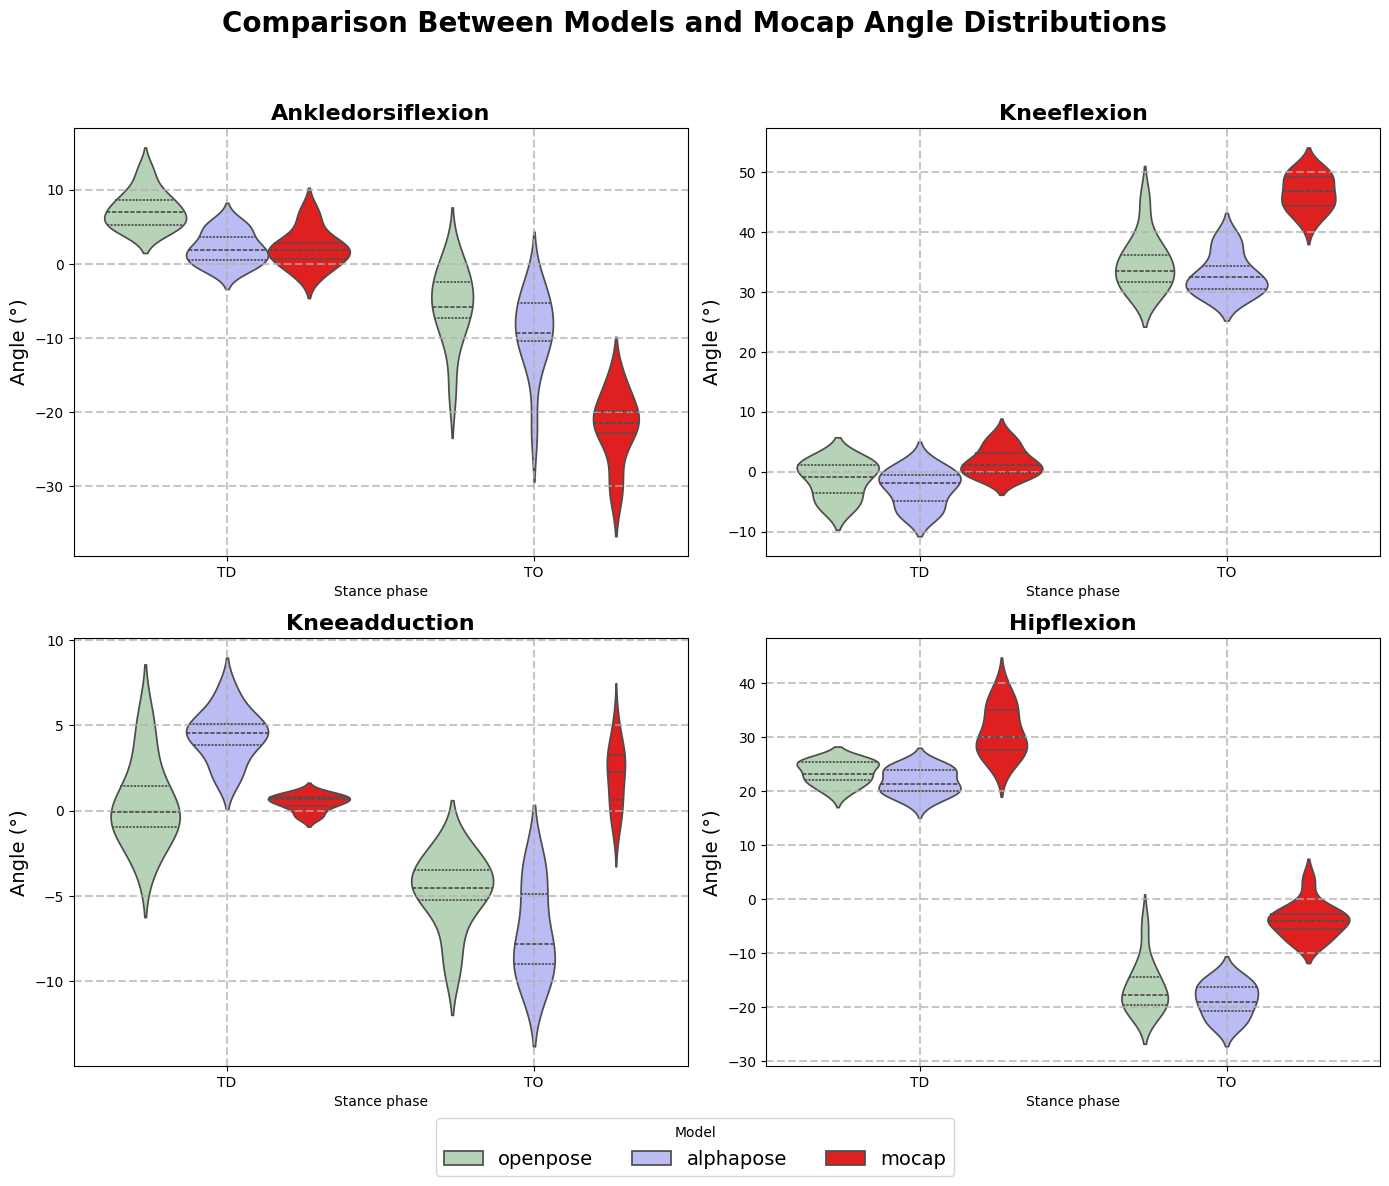

In [11]:

# Load tidy data (adjust path if needed)
df = pd.read_csv("results/tidy_results.csv")

# Assume your 'Angle' column contains strings like "TD_Kneeflexion" or "TO_Kneeflexion".
# Create new columns 'Stance phase' and 'BaseAngle'
df = df[df["Angle"].str.contains("_")].copy()
df["Stance phase"] = df["Angle"].apply(lambda x: x.split("_")[0])
df["BaseAngle"] = df["Angle"].apply(lambda x: x.split("_")[1])

# Define the base angles of interest
relevant_angles = ["Ankledorsiflexion", "Kneeflexion", "Kneeadduction", "Hipflexion"]

# Filter the DataFrame for these base angles
df = df[df["BaseAngle"].isin(relevant_angles)]

# Define a custom palette using RGBA values (alpha set to 0.3)
colors = {
    "mocap": "#FF0000",
    "alphapose": "#B2B2FF",
    "openpose": "#B2D8B2"
}

# Create the "plots" directory if it doesn't exist
if not os.path.exists("plots"):
    os.makedirs("plots")

# Set up the 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Increased figure size for better visibility
axes = axes.flatten()  # Flatten to loop through easily

# Generate violin plots for each base angle
for i, base_angle in enumerate(relevant_angles):
    subset = df[df["BaseAngle"] == base_angle]
    
    sns.violinplot(ax=axes[i], x="Stance phase", y="Mean", hue="Model", data=subset,
                   palette=colors, dodge=True, inner="quartile")

    axes[i].set_title(base_angle, fontsize=16, fontweight='bold')  # Larger, bold subtitles
    axes[i].set_ylabel("Angle (°)", fontsize=14)
    axes[i].grid(True, linestyle="--", linewidth=1.5, alpha=0.7)  # Thicker grid lines

    # Hide individual legends (we will create one shared legend)
    axes[i].legend().remove()

# Add one **large title** for the entire figure
fig.suptitle("Comparison Between Models and Mocap Angle Distributions", fontsize=20, fontweight='bold')

# Create a single legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Model", loc="lower center", ncol=3, fontsize=14)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Leaves space at top for the large title
fig.subplots_adjust(bottom=0.1)
plot_filename = os.path.join("plots", "violin_2x2.png")
plt.savefig(plot_filename)
plt.show()